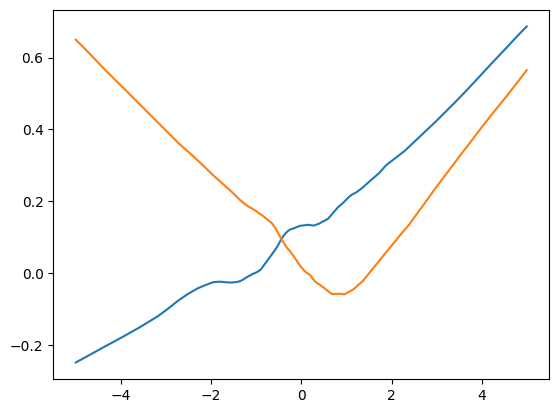

In [9]:
from networks.deep_ensemble_NN_model import GaussianMixtureMLP
from networks.MLP import MLP
from matplotlib import pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
class BSDP(torch.nn.Module):
    def __init__(self):
        super(BSDP, self).__init__()
        # initalize 5 models
        self.model1 = MLP(1,2,0)
        self.model2 = MLP(1,2,0)
        self.model3 = MLP(1,2,0)
        self.model4 = MLP(1,2,0)
        self.model5 = MLP(1,2,0)
        # initialize 5 prior models
        self.prior1 = MLP(1,2,0)
        self.prior2 = MLP(1,2,0)
        self.prior3 = MLP(1,2,0)
        self.prior4 = MLP(1,2,0)
        self.prior5 = MLP(1,2,0)
    
    def forward(self, x):
        # forward pass
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        out4 = self.model4(x)
        out5 = self.model5(x)
        # prior pass
        prior1 = self.prior1(x)
        prior2 = self.prior2(x)
        prior3 = self.prior3(x)
        prior4 = self.prior4(x)
        prior5 = self.prior5(x)
        # return
        return out1+prior1, out2+prior2, out3+prior3, out4+prior4, out5+prior5
    
    def diversity_init(self,p_net):
        """initalzie the networks with diversity to make the softmax output different in each member"""

        for i in tqdm(range (500)):
            high=self.env.observation_space.high
            low=self.env.observation_space.low
            s=[]
            for i in range(len(high)):
                try:
                    s.append(torch.FloatTensor(128,1).uniform_(low[i],high[i]))
                except:
                    s.append(torch.FloatTensor(128,1).uniform_(-100,100))
            data=torch.cat(s,1)

            model_index=torch.randint(0,self.num_models,(1,))
            model_p = getattr(p_net, 'model_' + str(model_index.item()))
            model = getattr(self, 'model_' + str(model_index.item()))

            optim=torch.optim.AdamW(model_p.parameters(),lr=0.01)
            # forward
            if self.var_net_flag:
                mean = torch.softmax(model(data)[:,:self.outputs]+model_p(data)[:,:self.outputs],dim=1)

                with torch.no_grad():
                    means=self(data)[0]+p_net(data)[0]
                    target=torch.softmax(means.median(0)[0],dim=1)

            else:
                
                mean = torch.softmax(model(data)+model_p(data),dim=1)
                means=self(data)+p_net(data)

                with torch.no_grad():
                    target=torch.softmax(means.median(0)[0],dim=1).detach()

            # compute the loss    
            optim.zero_grad()
            # loss=-F.mse_loss(mean,target)*100-means.var(0).mean()*100
            criterion = nn.KLDivLoss(reduction='batchmean')
            loss=-criterion(mean,target)+means.mean()**2
            
            # optimize
            loss.backward()
            optim.step()
            
            
            
            
x=torch.arange(-5,5,0.01).reshape(-1,1)


BSDP_model = BSDP()
y1=BSDP_model(x)

plt.plot(x,y1[0].detach().numpy(),label='model1')




